In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import henon_map_cpp as hm
import pandas as pd
from tqdm.notebook import tqdm
from numba import njit
import datetime

In [6]:
OMEGA_X = 0.31 # 0.168
OMEGA_Y = 0.32 # 0.201
EPSILON = 32.0
MU = 0.01

ANGULAR_SAMPLES = 100
LINEAR_SAMPLES = 100

R_MAX = 0.25

# MAX_TURNS = int(1e7) # Elapsed time on a 20 thread CPU with 100x100 samples is 0:05:14
MAX_TURNS = int(1e8) # Elapsed time on a Tesla V100 with 100x100 samples is 0:05:45

DA_SAMPLING_TIMES = np.logspace(1, np.log10(MAX_TURNS), num=1000, dtype=int)

In [7]:
@njit
def get_first_unstable_point(radial_data, radiuses, threshold):
    for i in range(len(radial_data)):
        if radial_data[i] < threshold:
            return radiuses[i]
    return radiuses[-1]

In [8]:
angles = np.linspace(0, np.pi / 2, ANGULAR_SAMPLES)
radiuses = np.linspace(0, R_MAX, LINEAR_SAMPLES + 1)[1:]

rr, aa = np.meshgrid(radiuses, angles)

xx = rr * np.cos(aa)
x = xx.flatten()
px = np.zeros_like(x)
yy = rr * np.sin(aa)
y = yy.flatten()
py = np.zeros_like(y)

In [23]:
particles = hm.particles(x, px, y, py)

# start chronometer
start = datetime.datetime.now()

tracker = hm.henon_tracker(MAX_TURNS, OMEGA_X, OMEGA_Y, "sps", epsilon=EPSILON)
tracker.track(particles, MAX_TURNS, mu=MU, barrier=10.0)
steps = particles.get_steps()

# end chronometer
end = datetime.datetime.now()

# print elapsed time
print("Elapsed time: {}".format(end - start))

creating gpu tracker
Elapsed time: 0:00:03.549366


In [9]:
#### CPU FORCED VERSION
# particles = hm.particles(x, px, y, py, force_CPU=True)

# # start chronometer
# start = datetime.datetime.now()

# tracker = hm.henon_tracker(MAX_TURNS, OMEGA_X, OMEGA_Y, "sps", epsilon=EPSILON, force_CPU=True)
# tracker.track(particles, MAX_TURNS, mu=MU, barrier=10.0)
# steps = particles.get_steps()

# # end chronometer
# end = datetime.datetime.now()

# # print elapsed time
# print("Elapsed time: {}".format(end - start))

Elapsed time: 0:05:13.861826


In [14]:
steps = particles.get_steps()
s = steps.flatten()

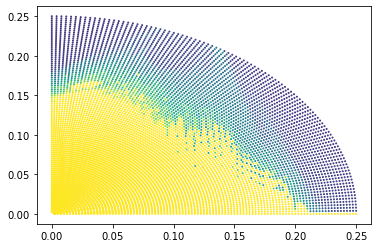

In [15]:
cmap = matplotlib.cm.get_cmap('viridis')
s_c = cmap(np.log10(s) / np.log10(MAX_TURNS))

plt.scatter(x, y, c=s_c, s=1)

In [16]:
radiuses_values = {}
da_values = {}

for t in tqdm(DA_SAMPLING_TIMES):
    da_radiuses = []
    ss = steps.reshape((ANGULAR_SAMPLES, LINEAR_SAMPLES))
    for i in range(ANGULAR_SAMPLES):
        da_radiuses.append(get_first_unstable_point(ss[i], radiuses, t))
    da_radiuses = np.array(da_radiuses)
    radiuses_values[t] = da_radiuses
    # simple mean of radiuses...
    da_values[t] = np.mean(da_radiuses)

  0%|          | 0/1000 [00:00<?, ?it/s]

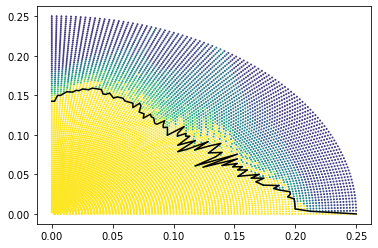

In [17]:
cmap = matplotlib.cm.get_cmap('viridis')
s_c = cmap(np.log10(s) / np.log10(MAX_TURNS))

plt.scatter(x, y, c=s_c, s=1)
plt.plot(radiuses_values[MAX_TURNS] * np.cos(angles), radiuses_values[MAX_TURNS] * np.sin(angles), c='k')

In [18]:
df = pd.DataFrame([radiuses_values, da_values]).T
# name the columns "radiuses" and "da"
df.columns = ["radiuses", "da"]
# name the index "t"
df.index.name = "t"
df

,radiuses,da
t,,
10,"[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2...",0.25
11,"[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2...",0.25
12,"[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2...",0.25
13,"[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2...",0.25
14,"[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2...",0.25
...,...,...
93750150,"[0.25, 0.2125, 0.2, 0.2, 0.2, 0.2, 0.2, 0.195,...",0.160125
95275004,"[0.25, 0.2125, 0.2, 0.2, 0.2, 0.2, 0.2, 0.195,...",0.160125
96824661,"[0.25, 0.2125, 0.2, 0.2, 0.2, 0.2, 0.2, 0.195,...",0.160125


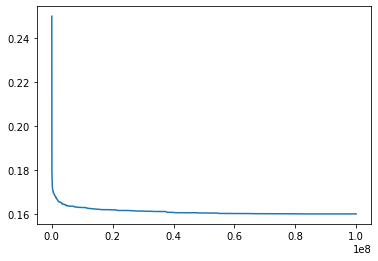

In [19]:
plt.plot(df.da)